# 0. Set-up
## Libraries
Loading required packages.

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

## GPU
Checking for GPU and switching to GPU if available.

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


# 1. Data Loaders for CIFAR-10 dataset
Function to download the dataset and load it to memory. Data augmentation is also carried out in this function. Here are the data augmentation techniques that have been applied:
1. A random horizontal flip.
2. A random rotation between -5 and 5 degrees.

In [70]:
# Function to download the CIFAR-10 dataset and then load it into memory
def load_data_cifar(batch_size, resize=None):
    trans = [torchvision.transforms.ToTensor()]
    # Data augmentation is carried out by adding transformations to this matrix. These will only be applied to train data
    trans_train = [ torchvision.transforms.ToTensor(),
                    torchvision.transforms.RandomHorizontalFlip(), # Random horizontal flip
                    torchvision.transforms.RandomRotation(degrees = (-5, 5))] # Random rotation between -5 andd 5 degrees
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    trans = torchvision.transforms.Compose(trans)
    trans_tran = torchvision.transforms.Compose(trans_train)
    # The transformations in trans_tran are only applied to the train data
    cifar_train = torchvision.datasets.CIFAR10(root="./data", train=True, transform=trans_tran, download=True)
    cifar_test = torchvision.datasets.CIFAR10( root="./data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(cifar_train, batch_size, shuffle=True, num_workers=2),
            torch.utils.data.DataLoader(cifar_test, batch_size, shuffle=False, num_workers=2))

# 2. Neural Network
## Intermediate Block
The `Block` class in the code implements our intermediate block. It follows the instructions explained in the assignment document. It only has convolutional layers and a fully connected layer at the end. Here are its important features:
1. **Convolutional layers:** The block contains four convolutional layers. Each receives the same input image and outputs its own image. The parameters of each layer (`kernel_size`, `padding`, and `stride`) are set so that all the layers output images of the same size.
2. **Normalization and activation:** Output of each layer is normalized and sent to a ReLU activation function.
3. **Fully connected layer:** There is one fully connected (linear) layer at the end to compute the vector $a$. The vector $m$ is computed in the forward function by computing the average value of each channel and storing into a variable `m`. This is then passed to the linear layer to compute the vector $a$. This layer has output units set to 4, which is the number of convolutional layers in our intermediate block.
4. **Output formula:** The vector $a$ (stored in variable `a`) has four elements, the same as the number of convolutional layers in our intermediate block. Each element of `a` is multiplied by the output of each of our layers and all the outputs of the convolutional layers are simply summed together. This gives us the out vector that we output for the block.


In [71]:
class Block(torch.nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Block, self).__init__()
        # Convolutional layer 1
        self.conv1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=1, padding=0, stride=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channels)
        self.relu1 = torch.nn.ReLU()
        # Convolutional layer 2
        self.conv2 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channels)
        self.relu2 = torch.nn.ReLU()
        # Convolutional layer 3
        self.conv3 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=5, padding=2, stride=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channels)
        self.relu3 = torch.nn.ReLU()
        # Convolutional layer 4
        self.conv4 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, stride=1)
        self.bn4 = torch.nn.BatchNorm2d(output_channels)
        self.relu4 = torch.nn.ReLU()
        # Fully connected layer
        self.lin = torch.nn.Linear(input_channels, 4)

    def forward(self, x):
        out1 = self.conv1(x)
        out1 = self.bn1(out1)
        out1 = self.relu1(out1)

        out2 = self.conv2(x)
        out2 = self.bn2(out2)
        out2 = self.relu2(out2)

        out3 = self.conv3(x)
        out3 = self.bn3(out3)
        out3 = self.relu3(out3)

        out4 = self.conv4(x)
        out4 = self.bn4(out4)
        out4 = self.relu4(out4)

        m = x.mean(dim = (0, 2, 3))
        a = self.lin(m)

        # Code to check the output size of each layer
        # print("a", a.size())
        # print("1", out1.size())
        # print("2", out2.size())
        # print("3", out3.size())
        # print("4", out4.size())

        # The output formula as specified in the assignment
        out = a[0]*out1 + a[1]*out2 + a[2]*out3 + a[3]*out4

        return out

## Macroblock
The `Macroblock` class is added to produce cleaner code. It adds a level of abstraction so that we don't have to write a single long code for multiple blocks. This allows us to elegantly write how we wish to use our Block class. Here are its important features:
1. **Blocks:** The macroblock has five blocks in succession: the output of the preceding block is the input of the next one. Here are the tuples of the input/output channels for our five blocks:
 - (3, 15)
 - (15, 30)
 - (30, 54)
 - (54, 75)
 - (75, 96)
2. We can see that the number of channels increase after each successive block. This is done intentionally to ensure that we have more capacity to continue to learn at each successive block.


In [72]:
class Macroblock(torch.nn.Module):
    def __init__(self):
        super(Macroblock, self).__init__()

        # Blocks are defined here
        self.b1 = Block(3, 15)
        self.b2 = Block(15, 30)
        self.b3 = Block(30, 54)
        self.b4 = Block(54, 75)
        self.b5 = Block(75, 96)

    def forward(self, x):
        # Here is how the output is generated from the macro block
        # Input of the first block is the image from the train dataset 
        # Input of other blocks is the output of the preceding block
        out = self.b1(x)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
    
        return out

## Output Block
The `OutBlock` class implements our output block. Here are its important features:
1. **Input:** The output block's input is the output of our Macroblock (also the output of our last intermediate block, and the output of our last convolutional layer).
2. **Transformations:** There are two things we do to the input before we send it to the fully connected layer:
(a) We calculate the average of all channels using `AdaptiveAvgPool2d`. This applies a 2D pool over the input.
(b) We reduce the number of dimensions by using `Flatten`.
3. **Fully connected layer:** This linear layer has output channels set to the number we specified in the constructor. Later we will see that this number is 10 since that is required by us. The number of categories in our input data is 10.
4. **Output:** The output block's output channels are 10.


In [73]:
class OutBlock(torch.nn.Module):
    def __init__(self, output_channels):
        super(OutBlock, self).__init__()

        self.output_channels = output_channels
        # For computing channel averages
        self.channel_avg = torch.nn.AdaptiveAvgPool2d((1, 1))
        # For reducing the dimensions (dropping the redundant dimensions)
        self.flatten = torch.nn.Flatten()
        # Fully connected layer: reduces input channels to output channels
        self.linear = torch.nn.Linear(96, self.output_channels)

    def forward(self, x):
        # The transformations/layers are applied successively
        # print("\nintermediate block output", x.size())
        m = self.channel_avg(x)
        # print("\nchannel_avg output", m.size())
        m = self.flatten(m)
        # print("\nflatten output", m.size())
        o = self.linear(m)
        # print("\nlinear output", o.size())
        return o

## Model
The `Model` class implements model. It simply contains our `Macroblock` and `OutBlock` instances. Its constructor also accepts the number of outputs.

In [74]:
class Model(torch.nn.Module):
    def __init__(self, num_outputs):
        super(Model, self).__init__()

        self.num_outputs = num_outputs
        # Macroblock instance
        self.mb1 = Macroblock()
        #OutBlock instance
        self.outBlock = OutBlock(output_channels = num_outputs)

    def forward(self, x):
        # Output generated by applying successively
        out = self.mb1(x)
        out = self.outBlock(out)
        return out

# 3. Training and Testing
## Hyperparameters
Here we specify some hyperparameters. Batch size is set at `128`. We will conduct `100` training epochs.

In [75]:
# Hyperparameters
batch_size = 128
num_epochs = 100

The initial weights have been assigned using Xavier initialization.

In [76]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

num_outputs = 10

model = Model(10).to(device) # Creates and moves the model to `device`
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

Model(
  (mb1): Macroblock(
    (b1): Block(
      (conv1): Conv2d(3, 15, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (conv3): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn3): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU()
      (conv4): Conv2d(3, 15, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn4): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu4): ReLU()
      (lin): Linear(in_features=3, out_features=4, bias=True)
    )
    (b2): Block(
      (conv1): Conv2d(15, 30, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(30, eps=1e-05, m

We have set the learning rate (`lr`) to `0.01`. The optimizer that has been used is `Adamax`.

In [77]:
lr = 0.01
optimizer = optim.Adamax(model.parameters(), lr=lr)

In [78]:
train_iter, test_iter = load_data_cifar(batch_size) # Loads the fashion CIFAR-10 dataset. `train_iter` and `test_iter` are `DataLoader` objects.
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # Pre-defined class labels

Files already downloaded and verified
Files already downloaded and verified


In [79]:
loss = torch.nn.CrossEntropyLoss()

## Execution of Training and Testing
Code here is borrwed from the labs.

In [80]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

# Example: 1 correct classification,
y = torch.tensor([2, 1])
logits = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0.2, 0.3]])
print(correct(logits, y))

tensor(1.)


In [81]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n)

In [82]:
model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

Training accuracy: 0.09999999403953552. Testing accuracy: 0.09999999403953552.


## Epochs
Here we execute our training epochs and print out training and test accuracy affter each epoch.

In [83]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct))

        end_time = time.perf_counter()

        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.


Epoch 1/100.
Training accuracy: 0.3198399841785431. Testing accuracy: 0.29339998960494995. Duration: 23.561s.

Epoch 2/100.
Training accuracy: 0.47457998991012573. Testing accuracy: 0.4521999955177307. Duration: 23.613s.

Epoch 3/100.
Training accuracy: 0.6060400009155273. Testing accuracy: 0.5788999795913696. Duration: 23.525s.

Epoch 4/100.
Training accuracy: 0.5893599987030029. Testing accuracy: 0.5849999785423279. Duration: 23.527s.

Epoch 5/100.
Training accuracy: 0.6060199737548828. Testing accuracy: 0.6258000135421753. Duration: 23.728s.

Epoch 6/100.
Training accuracy: 0.6624599695205688. Testing accuracy: 0.6793999671936035. Duration: 23.572s.

Epoch 7/100.
Training accuracy: 0.7107399702072144. Testing accuracy: 0.7038999795913696. Duration: 23.548s.

Epoch 8/100.
Training accuracy: 0.8004599809646606. Testing accuracy: 0.786899983882904. Duration: 23.716s.

Epoch 9/100.
Training accuracy: 0.8084799647331238. Testing accuracy: 0.7871999740600586. Duration: 23.703s.

Epoch 10

## Graphs of loss and accuracy
Now we will display our loss for each traninig batch and training and testing accuracy for epoch on plots. We can see that our testing accuracy goes above 85%.

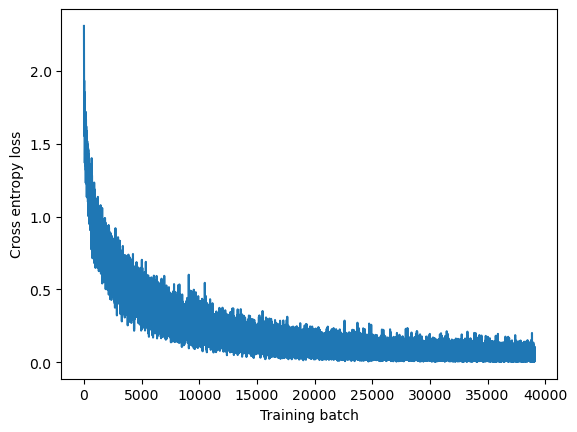

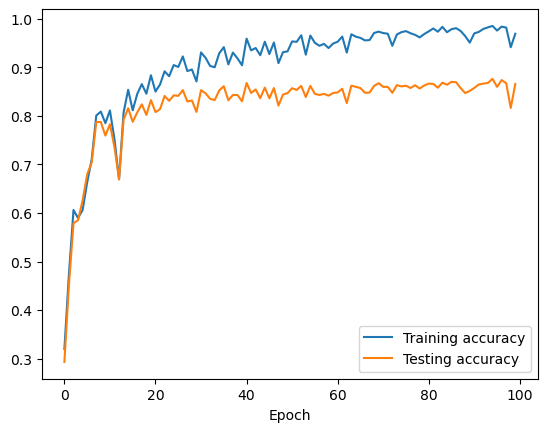

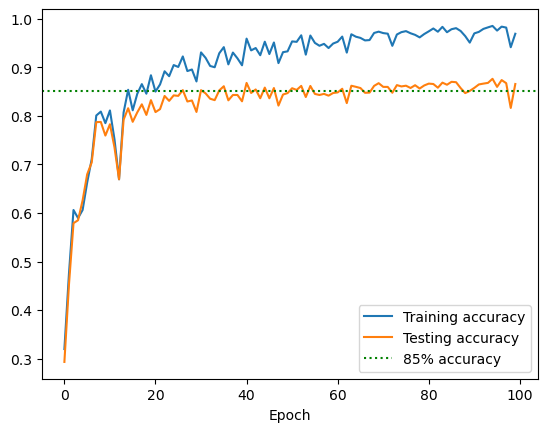

In [84]:
plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.axhline(y=0.85, color='g', linestyle=':', label='85% accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()